In [1]:
# Import all required dependencies
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import category_encoders as ce
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

## Initial data preparation
In this step, we'll read the source data and see what we've collected in the previous step.
We will also perform some transformations (mainly column datatype casting) to clean the source data before delving into the next steps.

In [2]:
# Read the data
X = pd.read_csv('vehicle_listing_data.csv')

In [3]:
# Let's take a first look at what we've got
X.head()

,Unnamed: 0,title,location,url,desc,price,seller,mileage,year,transmission,doors,hp
0,0,OPEL - CORSA 1.5D DT 74KW 100CV GSLINE,Barcelona,https://www.milanuncios.com/opel-de-segunda-ma...,- precio sujeto a la entrega de vehiculo a cam...,15.900 €,Profesional,5.542 kms,2020,Manual,5 puertas,102 CV
1,1,CITROEN - C4 PICASSO 1.6 HDI 110CV SEDUCTION,Madrid,https://www.milanuncios.com/citroen-de-segunda...,"Único propietario, procedencia nacional. uso a...",8.680 €,Profesional,135.542 kms,2012,Manual,5 puertas,112 CV
2,2,AUDI - A4 2.0 TDI 150 MULTITRONIC S LINE EDITION,La_coruna,https://www.milanuncios.com/audi-de-segunda-ma...,"* autos donaire, +150 vehiculos en stock \n* v...",13.900 €,Profesional,198.000 kms,2014,Automático,4 puertas,150 CV
3,3,FIAT - 500X CITY CROSS 1.4 MAIR 103KW140CV 4X2...,Madrid,https://www.milanuncios.com/fiat-de-segunda-ma...,"Único propietario, procedencia nacional/// uso...",16.920 €,Profesional,66.425 kms,2018,Automático,5 puertas,140 CV
4,4,PEUGEOT - 208 PURETECH 73KW 100CV ACTIVE,Alicante,https://www.milanuncios.com/peugeot-de-segunda...,- estamos 100% online y videollamada\n\n- cert...,15.800 €,Profesional,6.610 kms,2020,Manual,5 puertas,100 CV


In [4]:
# Drop first index column
X.drop(columns = X.columns[0], axis = 1, inplace = True)

In [5]:
# There is, particulary, one column with wrong values
X['seller'].unique()

# Let's see if this is a situation that we should handle in the scraping step, or there's just a few rows which values
# differ from the expected ones
X[(X.seller != 'Profesional') & (X.seller != 'Ver fotos')].shape

(13, 11)

In [6]:
# There are only 13 rows where the seller is mistaken in the dataset. Drop them.
X.drop(X[(X.seller != 'Profesional') & (X.seller != 'Ver fotos')].index, inplace = True)

# It's not going to make a difference, but to keep the data clean, let's change 'Ver fotos' with the other
# expected value rather than Professional: 'Particular'
def clean_seller(row):
    '''
    Checks the value of the Seller column for a given row and returns whether it's a 'Particular' or a 'Profesional' seller
    '''
    if row.seller == 'Ver fotos':
        return 'Particular'
    return row.seller

X['seller'] = X.apply(lambda row: clean_seller(row), axis = 1) 

In [7]:
def get_brand_model(row):
    '''
    Gets the Brand and Model for a given row, using information from the Title column
    '''
    tokenized = row.title.split(' - ')
    if len(tokenized) == 1:
        tokenized = row.title.split(' ')
        brand = tokenized[0]
        model = tokenized[1]
    else:
        brand = tokenized[0]
        model = ' '.join(tokenized[1].split(' ')[0:1])
    
    return (brand, model)

def clean_currency(x):
    '''
    If the given value is a string, returns a clean version without currency symbols or radix characters
    '''
    if isinstance(x, str):
        return(x.replace('€', '').replace('.', ''))
    return x

def clean_mileage(x):
    '''
    If the given instance is a string, returns a clean version removing the 'kms' suffix and radix characters.
    If a null value is given, return 0.
    '''
    if isinstance(x, str):
        return(x.replace('kms', '').replace('.', ''))
    if x is None:
        return 0
    return x

def clean_hp(x):
    '''
    If the given instance is a string, returns a clean version removing the 'CV' suffix.
    If a null value is given, return 0.
    '''
    if isinstance(x, str):
        return(x.replace('CV', ''))
    if x is None:
        return 0
    return x

In [8]:
# Apply transformations to obtain the brand and model for each vehicle
X['brand'] = X.apply(lambda row: get_brand_model(row)[0], axis=1)
X['model'] = X.apply(lambda row: get_brand_model(row)[1], axis=1)

# Apply transformations to clean the price, mileage and horse power columns. Eventually, cast them to integer
X.price = X.price.apply(clean_currency).astype('int')
X.mileage = X.mileage.apply(clean_mileage).astype('int')
X.hp = X.hp.apply(clean_hp).astype('int')

count      6040.000000
mean      19136.426490
std       16682.818307
min           1.000000
25%       10337.500000
50%       16490.000000
75%       24500.000000
max      320000.000000
Name: price, dtype: float64

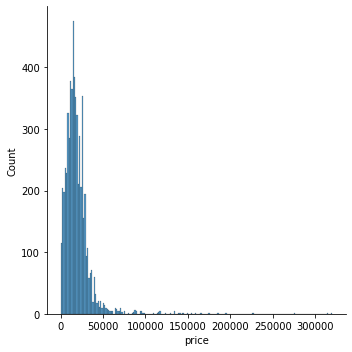

In [9]:
# Let's analyze the Price distribution
sns.displot(X['price'])

X.price.describe()

In [10]:
# In the previous cell, we noticed that the price range varies a lot. There are some ads with unreal prices (like 0€)
# and too few vehicles with prices that are way too high. Let's filter out this and focus only on the average cars.
X.drop(X[(X.price < 1000) | (X.price > 50000)].index, inplace = True)

c:\users\javier\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


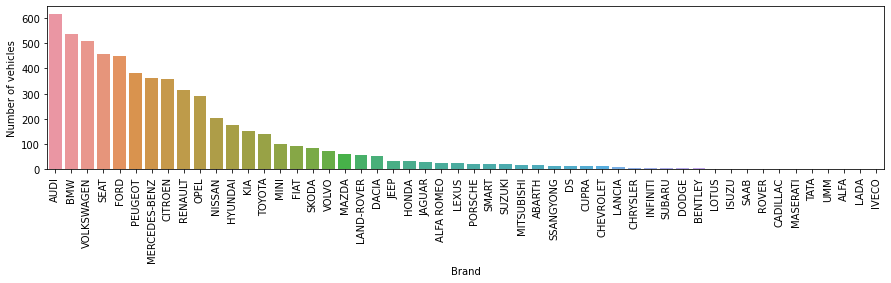

<Figure size 432x288 with 0 Axes>

In [11]:
# Let's also see the number of vehicles that we have for each brand
fig, ax = plt.subplots(figsize = (15,3))
plt1 = sns.countplot(X['brand'], order=pd.value_counts(X['brand']).index,)
plt1.set(xlabel = 'Brand', ylabel= 'Number of vehicles')
xticks(rotation = 90)
plt.show()
plt.tight_layout()

## Data preparation for machine learning models
In this step, we'll continue working with the data that we've just transformed.
Now, we should have a dataset with numerical values where expected and with readable string formats.
However, we still can have null or missing values and the data needs to be prepared for Machine Learning.

In this section we will separate training data from validation data. We will also perform preprocessing tasks for both numerical and categorical columns.

In [12]:
# Remove rows in which the target data is missing
X.dropna(axis=0, subset=['price'], inplace=True)

# Separate the target data into a Pandas Series and drop target and features that are not in our interest in the original dataset
y = X.price
X.drop(['price', 'title', 'url', 'desc'], axis=1, inplace=True)

# Break off the data into training and validation dataframes
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=5)

In [13]:
# Select the categorical columns and separate them into low and high cardinality lists. The threshold is set in 15 unique values.
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

low_cardinality_cols = [cname for cname in categorical_cols if X_train[cname].nunique() < 15]
high_cardinality_cols = [cname for cname in categorical_cols if X_train[cname].nunique() >= 15]

# Select numerical columns
numeric_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ('int', 'int32', 'int64')]

# Check that we're obtaining the expected results
print('# Low cardinality columns: ', low_cardinality_cols)
print('# High cardinality columns: ', high_cardinality_cols)
print('# Numerical columns: ', numeric_cols)

# Low cardinality columns:  ['seller', 'transmission', 'doors']
# High cardinality columns:  ['location', 'brand', 'model']
# Numerical columns:  ['mileage', 'year', 'hp']


In [14]:
# Preprocessing for numerical data
# We will imput the mean values for missing values in numerical columns
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
# We will use the most frequent values for missing values in categorical columns with low cardinality and one-hot encode them
onehot_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ce.OneHotEncoder(handle_unknown='ignore'))
])

# We will also use the most frequent values for missing values in categorical columns with high cardinality and hash encode them
hashing_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('hashing', ce.HashingEncoder())
])

# Bundle all the previous transformers together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('oh_cat', onehot_categorical_transformer, low_cardinality_cols),
        ('hash_cat', hashing_categorical_transformer, high_cardinality_cols)
    ])

## Machine Learning algorithms
Now, our data is finally ready and we'll create a model using different supervised Machine Learning algorithms and we will compare the mean absolute error that we obtain from each of these.

In [15]:
# Create a Cross Gradient Regressor model
# We're setting 1000 estimators, a learning rate of 0.05 and 4 jobs to run in paralel
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

# Create a pipeline that will perform all the preprocessing steps when fitting our datasets
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model for training data
pipeline.fit(X_train, y_train)

c:\users\javier\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['mileage', 'year', 'hp']),
                                                 ('oh_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['seller', 'transmission',
                                                   'doors']),
                                                 ('hash_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequ.

In [16]:
# Perform predictions over the validation data
preditions = pipeline.predict(X_valid)

# Evaluate the model
mae = mean_absolute_error(y_valid, preditions)
print('MAE: ', mae)

MAE:  1564.5062986606185
